In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

In [14]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

In [15]:
EXAMPLE_PROCESSED_DATA.train.metadata

,cluster,age,size,density,category,random_feature,sample_id
sample_303,Cluster_1,21.194224,4.538300,0.113699,A,-0.657083,sample_303
sample_259,Cluster_1,23.930016,6.864434,0.086318,A,1.280058,sample_259
sample_717,Cluster_4,53.074559,12.812042,1.111816,D,-0.046288,sample_717
sample_127,Cluster_5,53.380117,12.875572,0.525779,C,0.578705,sample_127
sample_576,Cluster_1,33.724569,2.429471,0.038608,B,0.657419,sample_576
...,...,...,...,...,...,...,...
sample_578,Cluster_1,28.165998,6.223125,0.286763,E,0.047880,sample_578
sample_946,Cluster_2,31.830988,4.929979,0.456122,B,0.126054,sample_946
sample_284,Cluster_3,40.607502,6.923138,2.313312,B,-0.288755,sample_284
sample_462,Cluster_1,40.449944,0.831899,0.096780,C,1.070726,sample_462


In [16]:
import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig

In [ ]:
vanillix = acx.Vanillix(
    config=DefaultConfig(
        epochs=200,
        learning_rate=0.005,
        n_layers=1,
        latent_dim=2,
        checkpoint_interval=50,
    ),
    data=processed_data,
)
vanillix.run()
vanillix.show_result()

In [ ]:
categorical_clusters = [
    "Cluster_" + str(c) for c in EXAMPLE_PROCESSED_DATA.train.metadata.cluster
]
categorical_clusters

In [ ]:
vanillix._visualizer.show_latent_space(
    result=vanillix.result,
    plot_type="2D-scatter",
    split="train",
    label_list=categorical_clusters,
    param=["Cluster"],
)
## Problem: during training sample order is shuffled due to batching. Order cannot be recovered with current result object.

In [ ]:
vanillix.result.model

## Ontix

In [17]:
import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig

from autoencodix.configs.ontix_config import OntixConfig

from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA


In [18]:
ont_lvl1 = dict()
ont_lvl2 = dict()

ont_lvl1["pwy-1"] = ["sub-pwy-1", "sub-pwy-2"]
ont_lvl1["pwy-2"] = ["sub-pwy-2"]
ont_lvl1["pwy-3"] = ["sub-pwy-1", "sub-pwy-3"]
# first third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-1"] = processed_data.train.feature_ids[
    : int(len(processed_data.train.feature_ids) / 3)
]
# second third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-2"] = processed_data.train.feature_ids[
    int(len(processed_data.train.feature_ids) / 3) : int(
        2 * len(processed_data.train.feature_ids) / 3
    )
]
# last third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-3"] = processed_data.train.feature_ids[
    int(2 * len(processed_data.train.feature_ids) / 3) : int(
        len(processed_data.train.feature_ids)
    )
]

# ont_lvl2["sub-pwy-1"] = ["gene-1", "gene-2"]
# ont_lvl2["sub-pwy-2"] = ["gene-3", "gene-4"]
# ont_lvl2["sub-pwy-3"] = ["gene-2", "gene-6"]

ontology_tuple = (ont_lvl1, ont_lvl2)


In [19]:
# Write each dictionary in ontology_tuple to a separate text file
for i, ont_dict in enumerate(ontology_tuple):
    file_name = f"ontology_level_{i + 1}.txt"
    with open(file_name, "w") as f:
        for key, values in ont_dict.items():
            for value in values:
                f.write(f"{value}\t{key}\n")
print("Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt")

Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt


In [20]:
ont_files = ["ontology_level_1.txt", "ontology_level_2.txt"]

In [21]:
from autoencodix.configs.default_config import DataInfo, DataConfig

# This will also FAIL validation because of the nested 'ROBUST' scaler
try:
    config = OntixConfig(
        data_config=DataConfig(
            data_info={
                "MODALITY_A": DataInfo(scaling="MINMAX"), # This one is ok
                "MODALITY_B": DataInfo(scaling="ROBUST"), # This one is NOT ok
            }
        )
    )
except Exception as e:
    print(f"✅ FAILED as expected:\n{e}")

✅ FAILED as expected:
1 validation error for OntixConfig
  Value error, Invalid scaling 'ROBUST' for modality 'MODALITY_B'. OntixConfig only permits ['MINMAX', 'NONE']. [type=value_error, input_value={'data_config': DataConfi...nnotation_columns=None)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


In [22]:
ontix = acx.Ontix(ontologies=ont_files, sep="\t", config=OntixConfig(epochs=5, learning_rate=0.005,n_layers=1), data=processed_data)
# ontix = acx.Ontix(ontologies=ontology_tuple, config=DefaultConfig(epochs=500, learning_rate=0.005,n_layers=1), user_data=processed_data)

In [23]:
ontix.run()

preprocessing
Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Epoch 1 - Train Loss: 826781.4258
Sub-losses: recon_loss: 826781.2891, var_loss: 2921.2477, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 117284.8047
Sub-losses: recon_loss: 117284.7891, var_loss: 395.1303, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 813799.1211
Sub-losses: recon_loss: 813792.1562, var_loss: 2813.3580, anneal_factor: 0.0025, effective_beta_factor: 0.0025
Epoch 2 - Valid Loss: 115733.1484
Sub-losses: recon_loss: 115731.9062, var_loss: 503.8763, anneal_factor: 0.0025, effective_beta_factor: 0.0025
Epoch 3 - Train Loss: 801746.5234
Sub-losses: recon_loss: 801119.5000, var_loss: 5260.0875, anneal_factor: 0.1192, effective_beta_factor: 0.1192
Epoch 3 

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x313eb3280>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3141dd5d0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3141dd810>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 201 × 3
    uns: 'var_names'
final_reconstruction: <au

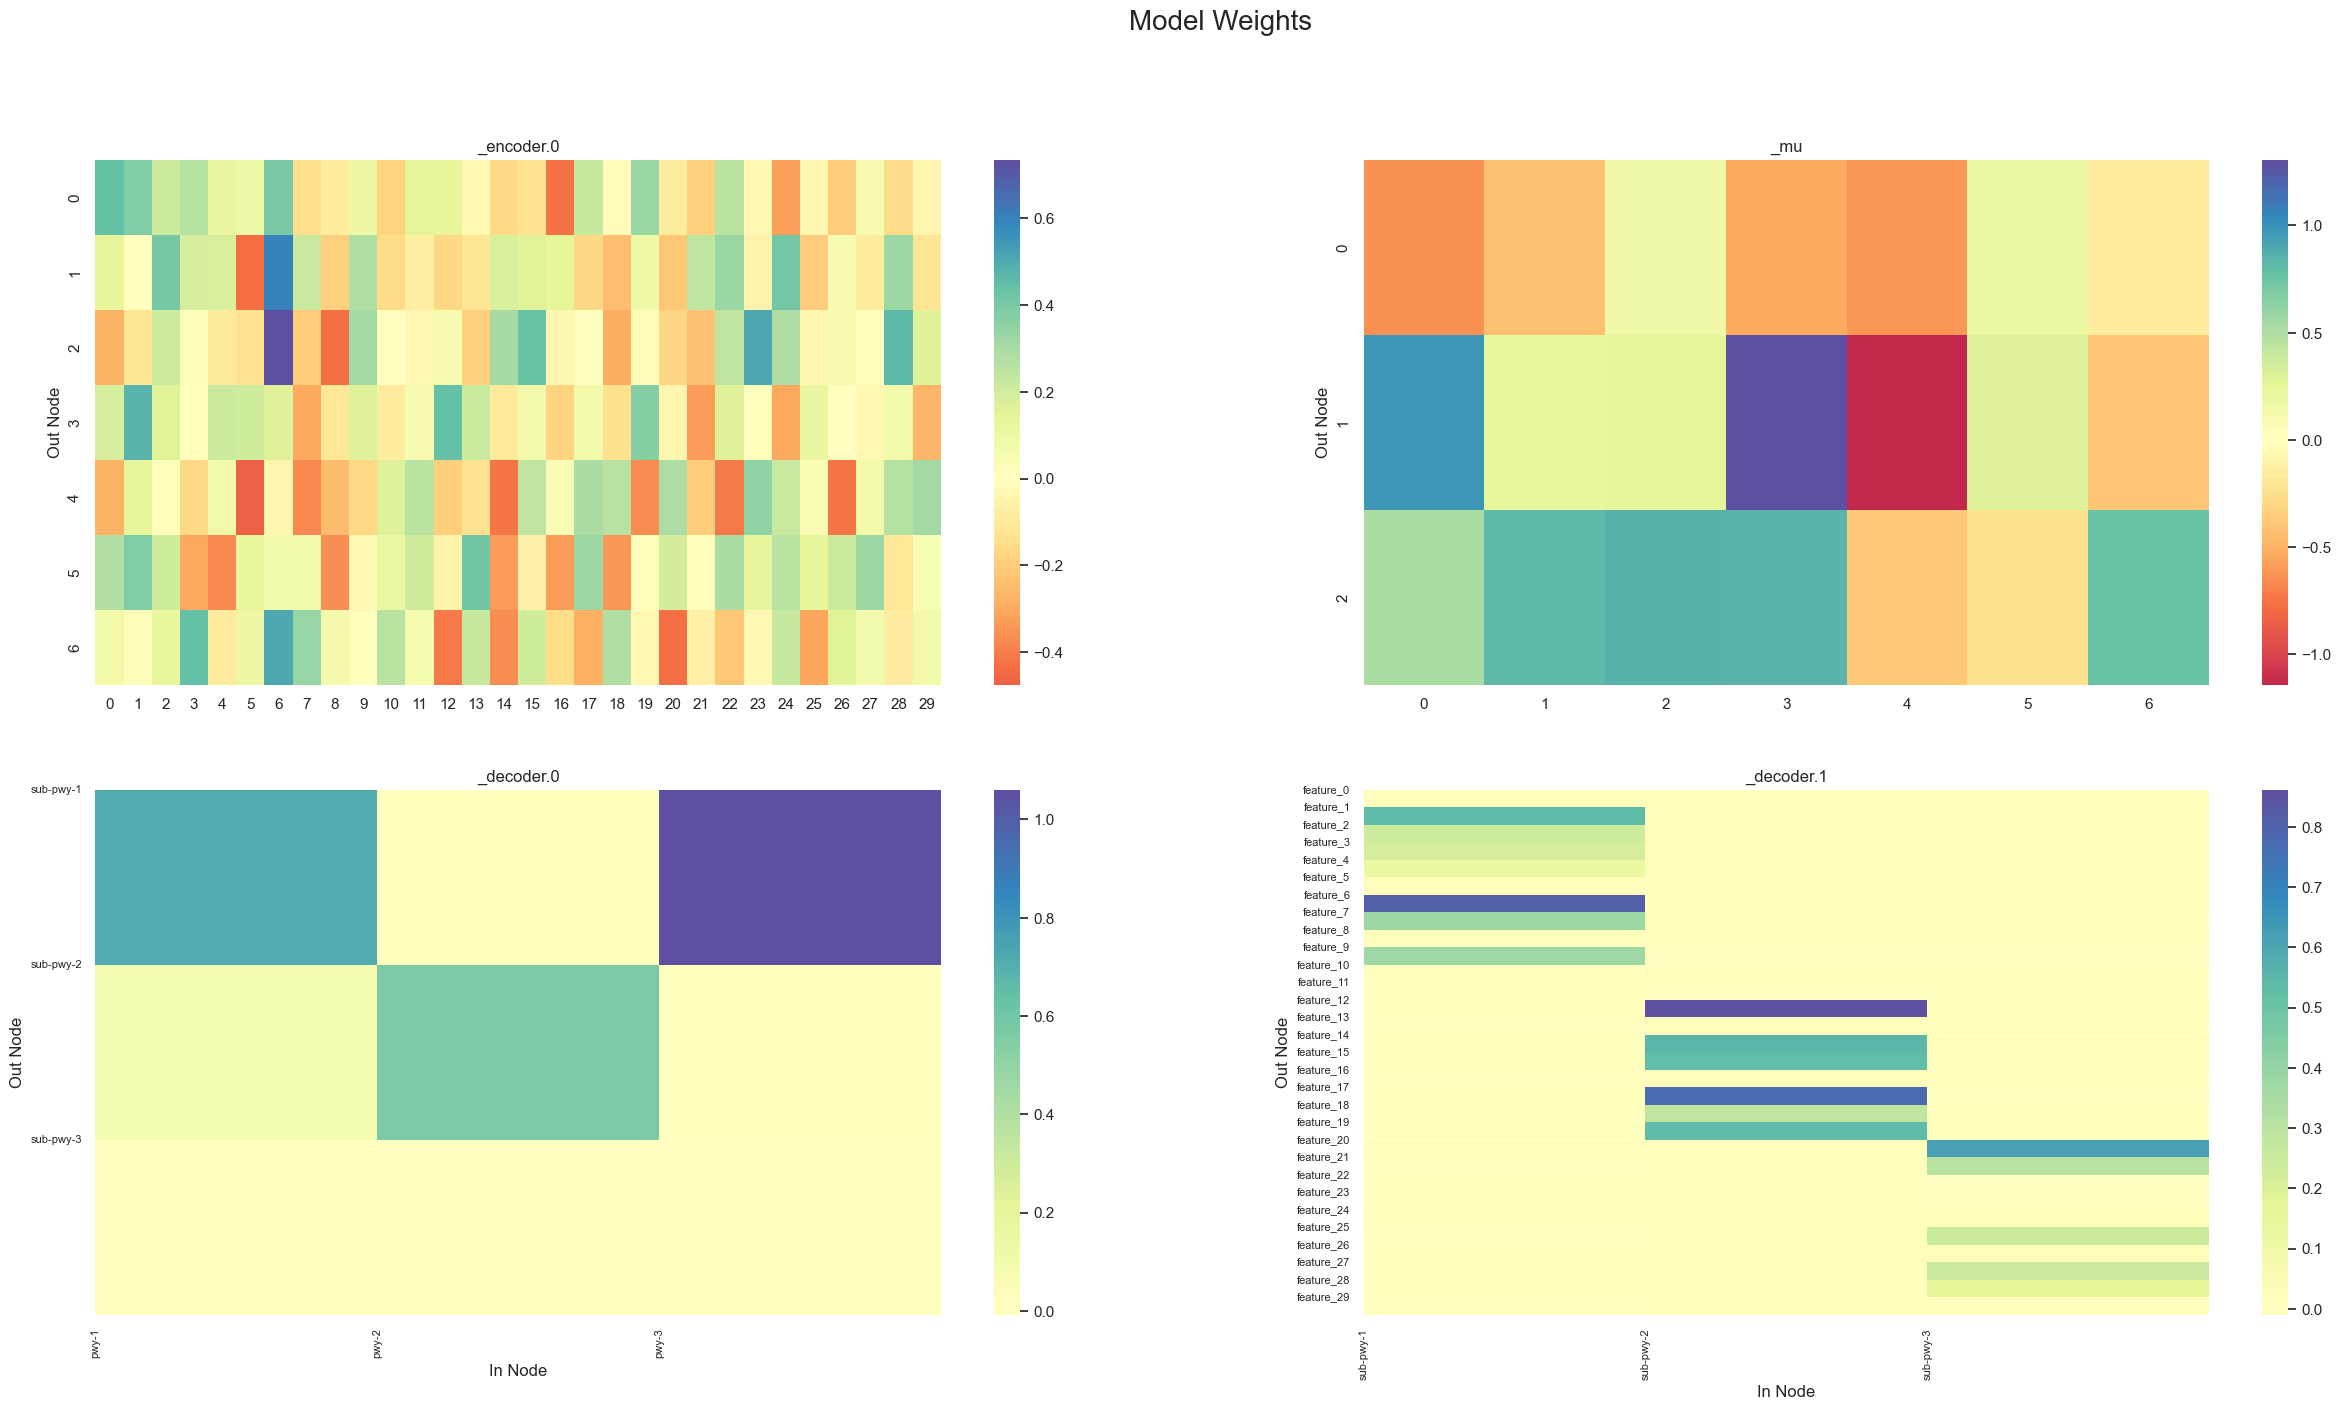

In [24]:
ontix._visualizer.show_weights()

Creating plots ...


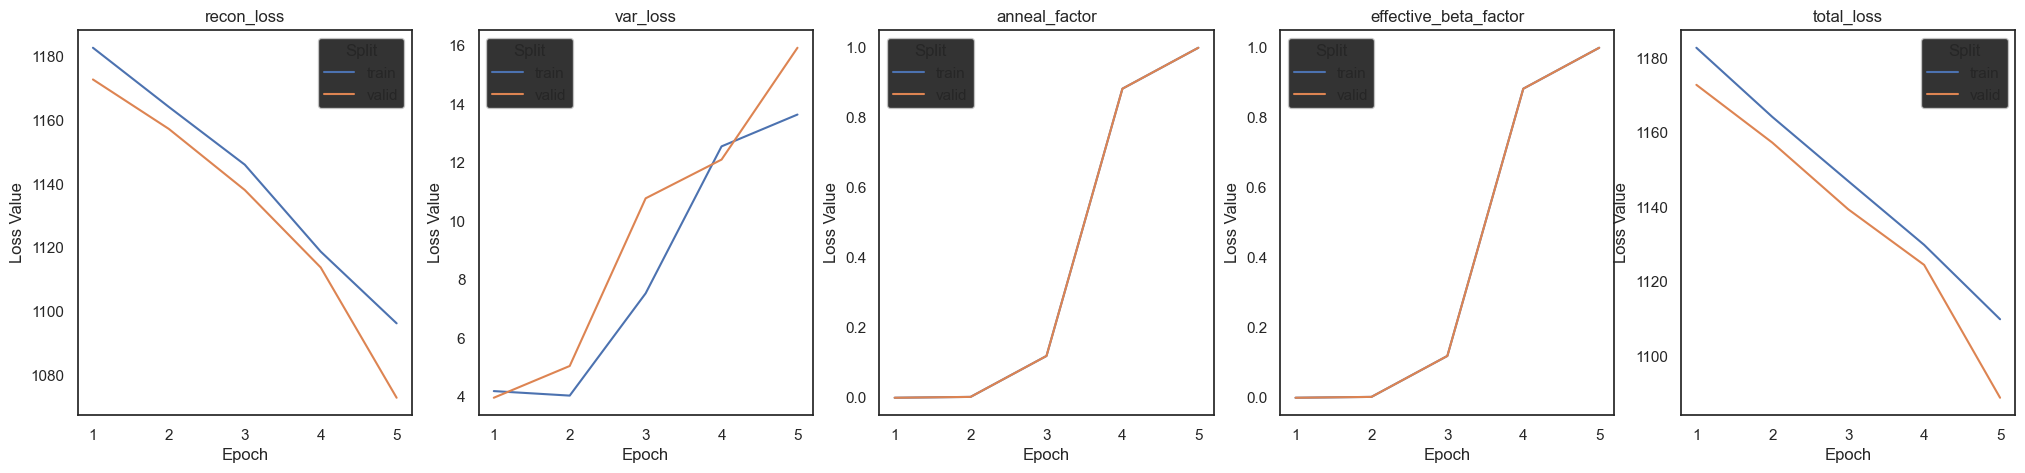

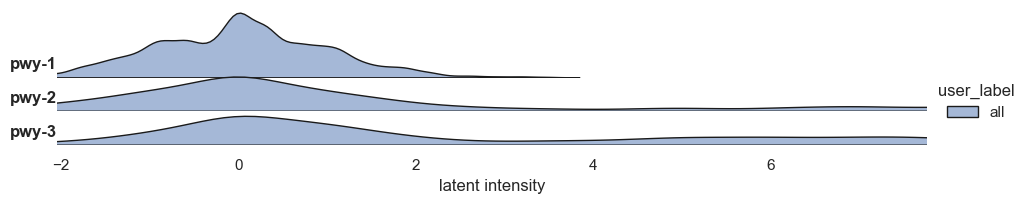

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


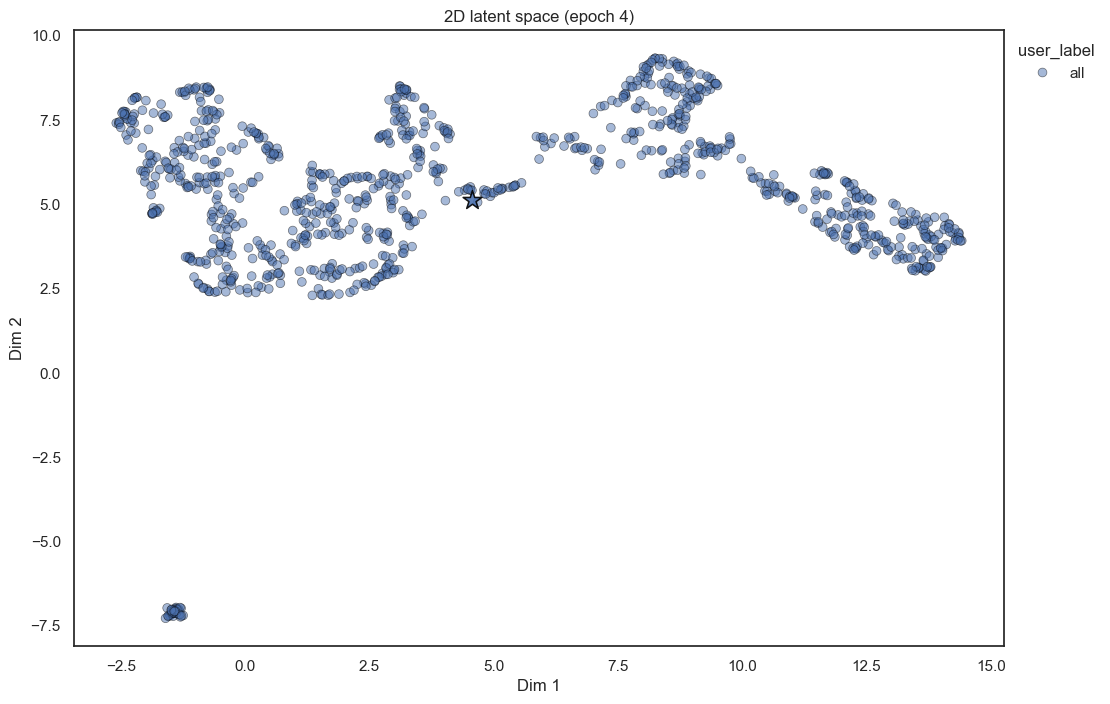

In [25]:
ontix.show_result()

In [26]:
categorical_clusters = [
    "Cluster_" + str(c) for c in EXAMPLE_PROCESSED_DATA.train.metadata.cluster
]
categorical_clusters
ontix._visualizer.show_latent_space(
    result=ontix.result,
    plot_type="2D-scatter",
    split="train",
    label_list=categorical_clusters,
    param="Cluster",
)

ValueError: Please provide parameter to plot as a list not as string. If you want to plot all parameters, set param to 'all' and labels to None.

In [ ]:
ontix.ontologies

In [ ]:
enumerate(ontix.result.model.ontologies)

In [ ]:
ontix.result.model.ontologies[1].keys()

In [ ]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

masks = ontix.result.model.masks

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, mask in enumerate(masks):
    sns.heatmap(np.array(mask), ax=axes[i], cmap="viridis")
    axes[i].set_title(f"Mask {i + 1}")
plt.tight_layout()
plt.show()

In [ ]:
ontix.preprocessed_data.train.feature_ids

In [ ]:
# Print all available attributes of ontix
print("Attributes of ontix:")
for attr in dir(ontix):
    if not attr.startswith("__"):
        print(attr)


In [ ]:
import seaborn as sns
import pandas as pd
import umap
import matplotlib.pyplot as plt


# Fit UMAP to reduce to 2D
umap_2d_seaborn = umap.UMAP(n_components=2, random_state=42)
embedding_seaborn = umap_2d_seaborn.fit_transform(EXAMPLE_PROCESSED_DATA.train.data)

# Create a DataFrame for plotting
umap_df = pd.DataFrame(
    {
        "UMAP1": embedding_seaborn[:, 0],
        "UMAP2": embedding_seaborn[:, 1],
        "Cluster": categorical_clusters,
    }
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=20, alpha=0.7
)
plt.title("2D UMAP projection of train data (colored by cluster_labels)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()